In [ ]:
# =================================================================
# CELL 1: INSTALL TIMM and IMPORT LIBRARIES
# =================================================================
# Install the timm library for EfficientNet models
!pip install -q timm

import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import timm

print("✅ Libraries installed and imported.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.7 MB/s eta 0:00:00
✅ Libraries installed and imported.


In [ ]:
# =================================================================
# CELL 2: SETUP AND COPY DATA FROM .ZIP ARCHIVE
# =================================================================
print("\n--- Setting up data ---")
# --- 1. SETUP PATHS AND MOUNT DRIVE ---
drive.mount('/content/drive')

# --- Define Paths ---
GDRIVE_ARCHIVE_PATH = "/content/drive/My Drive/UBC_Fashion_Project/final_mixed_partial_dataset.zip"
LOCAL_BASE_PATH = "/content/local_mixed_dataset"
LOCAL_ARCHIVE_PATH = "/content/final_mixed_partial_dataset.zip"

# --- Clean up previous local runs to ensure a fresh start ---
print("\nCleaning up any previous local data...")
shutil.rmtree(LOCAL_BASE_PATH, ignore_errors=True)
if os.path.exists(LOCAL_ARCHIVE_PATH):
    os.remove(LOCAL_ARCHIVE_PATH)
print("Cleanup complete.")

# --- 2. BULK COPY & EXTRACT OPERATION ---
print("\nCopying single .zip file from Google Drive to fast local disk...")
if not os.path.exists(GDRIVE_ARCHIVE_PATH):
    print(f"CRITICAL ERROR: The archive file was not found at '{GDRIVE_ARCHIVE_PATH}'")
    print("   Please make sure the path is correct and the file exists.")
else:
    shutil.copy(GDRIVE_ARCHIVE_PATH, LOCAL_ARCHIVE_PATH)
    print("✅ Archive copied to local disk.")
    print("\nExtracting dataset on local disk (this will be fast)...")
    !unzip -oq "{LOCAL_ARCHIVE_PATH}" -d "{LOCAL_BASE_PATH}/"
    print("✅ Extraction complete.")
    print("\n✅ LOCAL DATASET IS READY!")
    print(f"  - Base Path:       {LOCAL_BASE_PATH}")
    print(f"  - Train Path:      {os.path.join(LOCAL_BASE_PATH, 'train')}")
    print(f"  - Validation Path: {os.path.join(LOCAL_BASE_PATH, 'validation')}")
    print(f"  - Test Path:       {os.path.join(LOCAL_BASE_PATH, 'test')}")


--- Setting up data ---
Mounted at /content/drive

Cleaning up any previous local data...
Cleanup complete.

Copying single .zip file from Google Drive to fast local disk...
✅ Archive copied to local disk.

Extracting dataset on local disk (this will be fast)...
✅ Extraction complete.

✅ LOCAL DATASET IS READY!
  - Base Path:       /content/local_mixed_dataset
  - Train Path:      /content/local_mixed_dataset/train
  - Validation Path: /content/local_mixed_dataset/validation
  - Test Path:       /content/local_mixed_dataset/test


In [ ]:
# =================================================================
# CELL 3: CONFIGURATION AND DATALOADERS
# =================================================================
print("\n--- Configuring model and dataloaders ---")
# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_path = os.path.join(LOCAL_BASE_PATH, "train")
val_path = os.path.join(LOCAL_BASE_PATH, "validation")
test_path = os.path.join(LOCAL_BASE_PATH, "test")
best_model_path = "/content/drive/My Drive/ProMotionFx_CNN_Body/efficientnet_b3_body_pose_best.pth"

# Hyperparameters
img_size = (300, 300)
batch_size = 64
num_epochs = 10
learning_rate = 1e-4
patience = 3

# Transforms
train_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Datasets & Loaders
train_dataset = datasets.ImageFolder(train_path, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_path, transform=val_transforms)
class_names = train_dataset.classes

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
print("✅ Configuration and dataloaders are ready.")


--- Configuring model and dataloaders ---
✅ Configuration and dataloaders are ready.


In [ ]:
# =================================================================
# CELL 4: MODEL DEFINITION AND TRAINING
# =================================================================
print("\n--- Defining and Training the EfficientNet-B3 Model ---")
# Load pre-trained EfficientNet-B3
model = timm.create_model('efficientnet_b3', pretrained=True)

# Freeze all base layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final classifier
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 1),
    nn.Sigmoid()
)
model.to(device)

# Loss and Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

# Training loop with early stopping
best_val_acc = 0.0
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = (outputs >= 0.5).float()
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_acc = train_correct / train_total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            preds = (outputs >= 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss/len(train_loader):.4f}, Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss/len(val_loader):.4f}, Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save({
            'model_state': model.state_dict(),
            'class_names': class_names,
            'img_size': img_size,
            'best_val_acc': best_val_acc
        }, best_model_path)
        print(f"Validation accuracy improved. Best model saved to {best_model_path}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {patience} epochs with no improvement.")
            break

print("\n✅ Training Complete.")


--- Defining and Training the EfficientNet-B3 Model ---


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]


Epoch 1/10
Train Loss: 0.1730, Acc: 0.9597
Val Loss:   0.0587, Acc: 0.9871
Validation accuracy improved. Best model saved to /content/drive/My Drive/ProMotionFx_CNN_Body/efficientnet_b3_body_pose_best.pth

Epoch 2/10
Train Loss: 0.0529, Acc: 0.9843
Val Loss:   0.0364, Acc: 0.9901
Validation accuracy improved. Best model saved to /content/drive/My Drive/ProMotionFx_CNN_Body/efficientnet_b3_body_pose_best.pth

Epoch 3/10
Train Loss: 0.0370, Acc: 0.9890
Val Loss:   0.0307, Acc: 0.9909
Validation accuracy improved. Best model saved to /content/drive/My Drive/ProMotionFx_CNN_Body/efficientnet_b3_body_pose_best.pth

Epoch 4/10
Train Loss: 0.0313, Acc: 0.9902
Val Loss:   0.0609, Acc: 0.9914
Validation accuracy improved. Best model saved to /content/drive/My Drive/ProMotionFx_CNN_Body/efficientnet_b3_body_pose_best.pth

Epoch 5/10
Train Loss: 0.0254, Acc: 0.9919
Val Loss:   0.0228, Acc: 0.9934
Validation accuracy improved. Best model saved to /content/drive/My Drive/ProMotionFx_CNN_Body/effic


--- Evaluating the best model on the test set ---

Classification Report:
              precision    recall  f1-score   support

   full_body     0.9887    0.9957    0.9922     19485
partial_body     0.9957    0.9887    0.9921     19485

    accuracy                         0.9922     38970
   macro avg     0.9922    0.9922    0.9922     38970
weighted avg     0.9922    0.9922    0.9922     38970



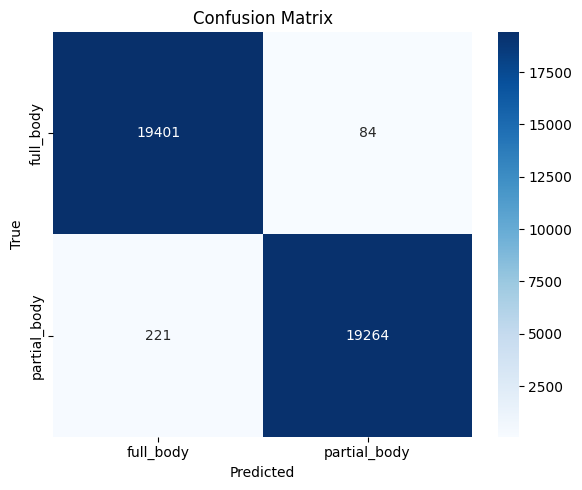

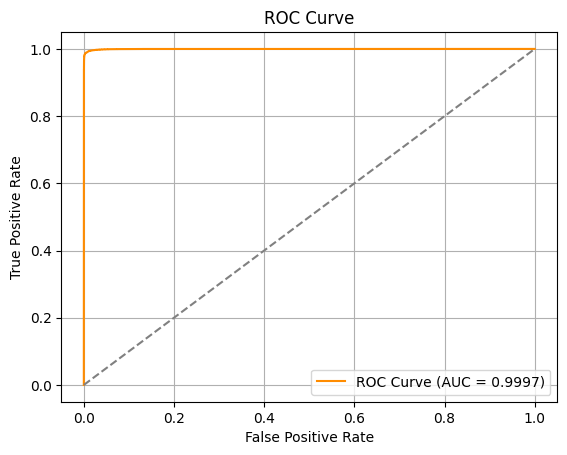


Overall Accuracy: 99.22%
Precision: 0.9957, Recall: 0.9887, AUC: 0.9997

✅ Evaluation Complete.


In [ ]:
import numpy as np

# =================================================================
# CELL 5: EVALUATION ON TEST SET
# =================================================================
print("\n--- Evaluating the best model on the test set ---")
# Load checkpoint
checkpoint = torch.load(best_model_path)
class_names = checkpoint['class_names']
img_size = checkpoint['img_size']

# Transforms for test set
test_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_dataset = datasets.ImageFolder(test_path, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Load the CORRECT model architecture
eval_model = timm.create_model('efficientnet_b3', pretrained=False)
num_ftrs = eval_model.classifier.in_features
eval_model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 1),
    nn.Sigmoid()
)
# Load the fine-tuned weights
eval_model.load_state_dict(checkpoint['model_state'])
eval_model.to(device)
eval_model.eval()

# Evaluation loop
all_labels = []
all_preds = []
all_probs = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = eval_model(images).squeeze()
        probs = outputs.cpu().numpy()
        preds = (outputs >= 0.5).float().cpu().numpy()
        labels_np = labels.cpu().numpy()

        all_labels.extend(labels_np)
        all_preds.extend(preds)
        all_probs.extend(probs)

# Metrics
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
auc_score = roc_auc_score(all_labels, all_probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Summary
acc = accuracy_score(all_labels, all_preds)
print(f"\nOverall Accuracy: {acc*100:.2f}%")
precision = cm[1,1] / (cm[0,1] + cm[1,1]) if (cm[0,1] + cm[1,1]) > 0 else 0
recall = cm[1,1] / (cm[1,0] + cm[1,1]) if (cm[1,0] + cm[1,1]) > 0 else 0
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc_score:.4f}")

print("\n✅ Evaluation Complete.")

--- Parsing log data to generate plots ---


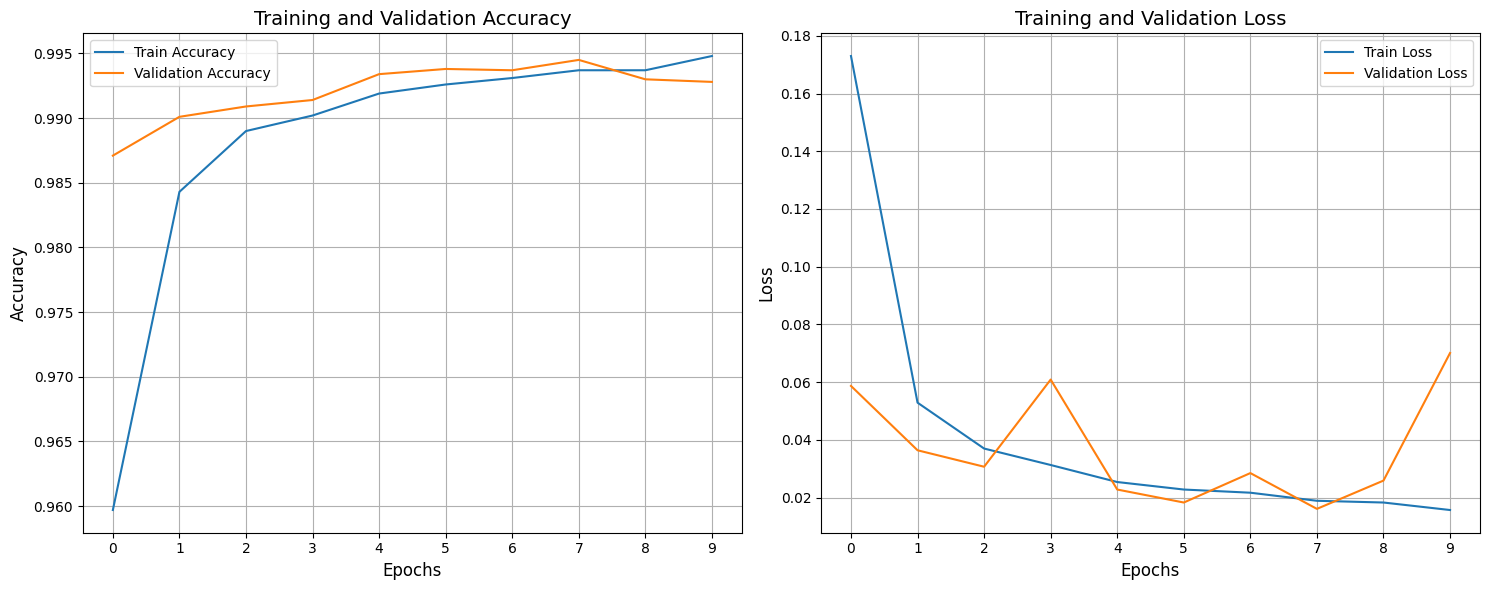


✅ Graphs generated successfully.


In [2]:
# =================================================================
# CELL 6 (FINAL): PARSE LOGS AND PLOT WITH CORRECT TITLES
# =================================================================
import re
import matplotlib.pyplot as plt
import numpy as np

# --- 1. LOG DATA FROM YOUR TRAINING CELL ---
log_data = """
Epoch 1/10
Train Loss: 0.1730, Acc: 0.9597
Val Loss:   0.0587, Acc: 0.9871
Validation accuracy improved. Best model saved to /content/drive/My Drive/ProMotionFx_CNN_Body/efficientnet_b3_body_pose_best.pth

Epoch 2/10
Train Loss: 0.0529, Acc: 0.9843
Val Loss:   0.0364, Acc: 0.9901
Validation accuracy improved. Best model saved to /content/drive/My Drive/ProMotionFx_CNN_Body/efficientnet_b3_body_pose_best.pth

Epoch 3/10
Train Loss: 0.0370, Acc: 0.9890
Val Loss:   0.0307, Acc: 0.9909
Validation accuracy improved. Best model saved to /content/drive/My Drive/ProMotionFx_CNN_Body/efficientnet_b3_body_pose_best.pth

Epoch 4/10
Train Loss: 0.0313, Acc: 0.9902
Val Loss:   0.0609, Acc: 0.9914
Validation accuracy improved. Best model saved to /content/drive/My Drive/ProMotionFx_CNN_Body/efficientnet_b3_body_pose_best.pth

Epoch 5/10
Train Loss: 0.0254, Acc: 0.9919
Val Loss:   0.0228, Acc: 0.9934
Validation accuracy improved. Best model saved to /content/drive/My Drive/ProMotionFx_CNN_Body/efficientnet_b3_body_pose_best.pth

Epoch 6/10
Train Loss: 0.0228, Acc: 0.9926
Val Loss:   0.0183, Acc: 0.9938
Validation accuracy improved. Best model saved to /content/drive/My Drive/ProMotionFx_CNN_Body/efficientnet_b3_body_pose_best.pth

Epoch 7/10
Train Loss: 0.0217, Acc: 0.9931
Val Loss:   0.0285, Acc: 0.9937

Epoch 8/10
Train Loss: 0.0189, Acc: 0.9937
Val Loss:   0.0161, Acc: 0.9945
Validation accuracy improved. Best model saved to /content/drive/My Drive/ProMotionFx_CNN_Body/efficientnet_b3_body_pose_best.pth

Epoch 9/10
Train Loss: 0.0183, Acc: 0.9937
Val Loss:   0.0259, Acc: 0.9930

Epoch 10/10
Train Loss: 0.0157, Acc: 0.9948
Val Loss:   0.0701, Acc: 0.9928
"""

# --- 2. EXTRACT THE METRICS USING REGULAR EXPRESSIONS ---
print("--- Parsing log data to generate plots ---")

train_loss = [float(x) for x in re.findall(r"Train Loss: ([\d.]+)", log_data)]
train_acc = [float(x) for x in re.findall(r"Train Loss: [\d.]+, Acc: ([\d.]+)", log_data)]
val_loss = [float(x) for x in re.findall(r"Val Loss:\s+([\d.]+)", log_data)]
val_acc = [float(x) for x in re.findall(r"Val Loss:\s+[\d.]+, Acc: ([\d.]+)", log_data)]

# --- 3. GENERATE THE PLOTS WITH THE REQUESTED STYLING AND ORIGINAL TITLES ---
epochs_trained = len(train_loss)
# The x-axis starts at 0 to match the example image style
epoch_range = range(epochs_trained)

plt.figure(figsize=(15, 6))

# Left Plot: Accuracy Curves
plt.subplot(1, 2, 1)
plt.plot(epoch_range, train_acc, color='tab:blue', label='Train Accuracy')
plt.plot(epoch_range, val_acc, color='tab:orange', label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=14) # Original Title
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(epoch_range)

# Right Plot: Loss Curves
plt.subplot(1, 2, 2)
plt.plot(epoch_range, train_loss, color='tab:blue', label='Train Loss')
plt.plot(epoch_range, val_loss, color='tab:orange', label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=14) # Original Title
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(epoch_range)

plt.tight_layout()
plt.show()

print("\n✅ Graphs generated successfully.")